# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [3]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
tasks = ["3Colors", "5Colors"]
choosenIndex = 0

In [5]:
print(X.shape)

(1400, 5)


In [6]:
X = np.concatenate((X[:200], X[600:800], X[1200:]), axis=0)
y = np.concatenate((y[:200], y[600:800], y[1200:]), axis=0)

In [7]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [9]:
print(y_test)

[0 0 1 2 1 1 1 1 2 0 0 2 2 0 0 0 2 2 1 1 0 1 2 1 2 2 2 0 2 2 1 1 0 1 0 2 0
 1 2 1 1 0 0 1 0 2 0 0 0 2 1 1 0 2 0 2 2 1 1 1 0 1 1 2 2 2 0 2 1 2 1 2 1 1
 2 0 2 0 2 2 1 0 1 0 1 0 0 2 0 0 1 1 2 1 2 2 1 0 2 0 1 2 1 0 1 0 0 2 1 0 0
 1 0 1 0 2 0 2 2 2]


## Model Spotting

In [10]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [11]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [12]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,72 0,06
LR - 0,67 0,03
CART - 0,93 0,03
SVC - 0,91 0,04
RF - 0,94 0,02


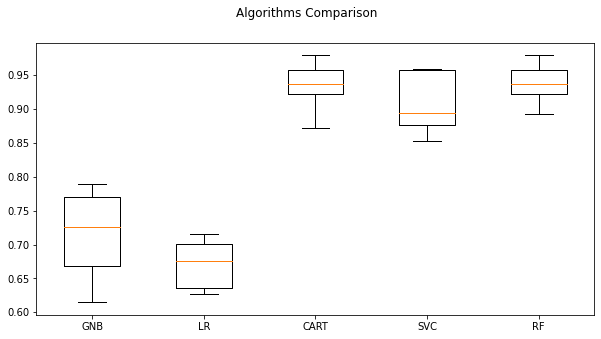

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione modelli sul Test Set

In [14]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports/'+'classification_report' + model_name +  '.csv', index = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.59      0.80      0.68        40
           2       0.81      0.72      0.76        40

    accuracy                           0.75       120
   macro avg       0.79      0.75      0.76       120
weighted avg       0.79      0.75      0.76       120

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.97      0.72      0.83        40
           1       0.54      0.85      0.66        40
           2       0.81      0.55      0.66        40

    accuracy                           0.71       120
   macro avg       0.77      0.71      0.72       120
weighted avg       0.77      0.71      0.72       120

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.93

# Valutazione Inferance Rate medio (|X_test| = 100)

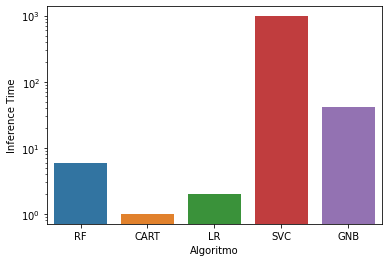

In [15]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

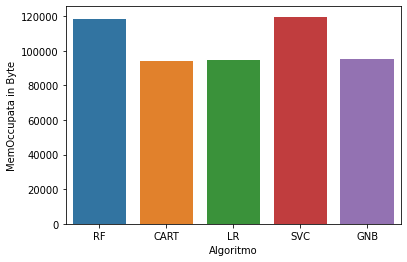

In [16]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [17]:
learn_rate = 0.001
def getNetwork(): 
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [19]:
EPOCHS = 500
BATCH_SIZE = 5
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
87/87 [==============================] - 0s 350us/step - loss: 3.7803 - accuracy: 0.3750
Epoch 2/500
87/87 [==============================] - 0s 322us/step - loss: 3.6306 - accuracy: 0.4144
Epoch 3/500
87/87 [==============================] - 0s 316us/step - loss: 3.5460 - accuracy: 0.4329
Epoch 4/500
87/87 [==============================] - 0s 320us/step - loss: 1.5

87/87 [==============================] - 0s 308us/step - loss: 0.6726 - accuracy: 0.7315
Epoch 75/500
87/87 [==============================] - 0s 302us/step - loss: 0.6651 - accuracy: 0.7014
Epoch 76/500
87/87 [==============================] - 0s 323us/step - loss: 0.6516 - accuracy: 0.7176
Epoch 77/500
87/87 [==============================] - 0s 319us/step - loss: 0.6558 - accuracy: 0.7106
Epoch 78/500
87/87 [==============================] - 0s 298us/step - loss: 0.6618 - accuracy: 0.7060
Epoch 79/500
87/87 [==============================] - 0s 310us/step - loss: 0.6603 - accuracy: 0.7153
Epoch 80/500
87/87 [==============================] - 0s 316us/step - loss: 0.6558 - accuracy: 0.7245
Epoch 81/500
87/87 [==============================] - 0s 338us/step - loss: 0.6512 - accuracy: 0.7083
Epoch 82/500
87/87 [==============================] - 0s 319us/step - loss: 0.6580 - accuracy: 0.7130
Epoch 83/500
87/87 [==============================] - 0s 320us/step - loss: 0.7137 - accuracy: 

87/87 [==============================] - 0s 309us/step - loss: 0.6386 - accuracy: 0.7130
Epoch 154/500
87/87 [==============================] - 0s 310us/step - loss: 0.6358 - accuracy: 0.7245
Epoch 155/500
87/87 [==============================] - 0s 326us/step - loss: 0.7038 - accuracy: 0.7361
Epoch 156/500
87/87 [==============================] - 0s 311us/step - loss: 0.6385 - accuracy: 0.7338
Epoch 157/500
87/87 [==============================] - 0s 317us/step - loss: 0.6307 - accuracy: 0.7338
Epoch 158/500
87/87 [==============================] - 0s 328us/step - loss: 0.6390 - accuracy: 0.7338
Epoch 159/500
87/87 [==============================] - 0s 320us/step - loss: 0.6721 - accuracy: 0.7477
Epoch 160/500
87/87 [==============================] - 0s 324us/step - loss: 0.6614 - accuracy: 0.7245
Epoch 161/500
87/87 [==============================] - 0s 330us/step - loss: 0.6811 - accuracy: 0.7083
Epoch 162/500
87/87 [==============================] - 0s 327us/step - loss: 0.6162 - a

87/87 [==============================] - 0s 298us/step - loss: 0.5862 - accuracy: 0.7407
Epoch 233/500
87/87 [==============================] - 0s 308us/step - loss: 0.6978 - accuracy: 0.6944
Epoch 234/500
87/87 [==============================] - 0s 322us/step - loss: 0.7047 - accuracy: 0.7130
Epoch 235/500
87/87 [==============================] - 0s 306us/step - loss: 0.6704 - accuracy: 0.7106
Epoch 236/500
87/87 [==============================] - 0s 305us/step - loss: 0.6504 - accuracy: 0.7292
Epoch 237/500
87/87 [==============================] - 0s 322us/step - loss: 0.6434 - accuracy: 0.7176
Epoch 238/500
87/87 [==============================] - 0s 315us/step - loss: 0.5958 - accuracy: 0.7384
Epoch 239/500
87/87 [==============================] - 0s 297us/step - loss: 0.5873 - accuracy: 0.7500
Epoch 240/500
87/87 [==============================] - 0s 322us/step - loss: 0.5778 - accuracy: 0.7755
Epoch 241/500
87/87 [==============================] - 0s 320us/step - loss: 0.6196 - a

87/87 [==============================] - 0s 327us/step - loss: 0.5868 - accuracy: 0.7546
Epoch 312/500
87/87 [==============================] - 0s 323us/step - loss: 0.5719 - accuracy: 0.7454
Epoch 313/500
87/87 [==============================] - 0s 322us/step - loss: 0.5964 - accuracy: 0.7639
Epoch 314/500
87/87 [==============================] - 0s 309us/step - loss: 0.6514 - accuracy: 0.7083
Epoch 315/500
87/87 [==============================] - 0s 317us/step - loss: 0.6460 - accuracy: 0.7315
Epoch 316/500
87/87 [==============================] - 0s 329us/step - loss: 0.6586 - accuracy: 0.7153
Epoch 317/500
87/87 [==============================] - 0s 325us/step - loss: 0.6094 - accuracy: 0.7431
Epoch 318/500
87/87 [==============================] - 0s 310us/step - loss: 0.5925 - accuracy: 0.7477
Epoch 319/500
87/87 [==============================] - 0s 309us/step - loss: 0.5631 - accuracy: 0.7685
Epoch 320/500
87/87 [==============================] - 0s 328us/step - loss: 0.6214 - a

87/87 [==============================] - 0s 303us/step - loss: 0.5526 - accuracy: 0.8056
Epoch 391/500
87/87 [==============================] - 0s 321us/step - loss: 0.5504 - accuracy: 0.7616
Epoch 392/500
87/87 [==============================] - 0s 335us/step - loss: 0.5276 - accuracy: 0.7917
Epoch 393/500
87/87 [==============================] - 0s 319us/step - loss: 0.5556 - accuracy: 0.7870
Epoch 394/500
87/87 [==============================] - 0s 316us/step - loss: 0.5749 - accuracy: 0.7292
Epoch 395/500
87/87 [==============================] - 0s 308us/step - loss: 0.6102 - accuracy: 0.7454
Epoch 396/500
87/87 [==============================] - 0s 337us/step - loss: 0.6011 - accuracy: 0.7500
Epoch 397/500
87/87 [==============================] - 0s 358us/step - loss: 0.6046 - accuracy: 0.7407
Epoch 398/500
87/87 [==============================] - 0s 325us/step - loss: 0.5958 - accuracy: 0.7569
Epoch 399/500
87/87 [==============================] - 0s 321us/step - loss: 0.5914 - a

87/87 [==============================] - 0s 324us/step - loss: 0.6328 - accuracy: 0.7222
Epoch 470/500
87/87 [==============================] - 0s 327us/step - loss: 0.6136 - accuracy: 0.7523
Epoch 471/500
87/87 [==============================] - 0s 305us/step - loss: 0.6277 - accuracy: 0.7407
Epoch 472/500
87/87 [==============================] - 0s 306us/step - loss: 0.5879 - accuracy: 0.7593
Epoch 473/500
87/87 [==============================] - 0s 318us/step - loss: 0.6227 - accuracy: 0.7245
Epoch 474/500
87/87 [==============================] - 0s 311us/step - loss: 0.6339 - accuracy: 0.7384
Epoch 475/500
87/87 [==============================] - 0s 318us/step - loss: 0.5696 - accuracy: 0.7477
Epoch 476/500
87/87 [==============================] - 0s 315us/step - loss: 0.5440 - accuracy: 0.7569
Epoch 477/500
87/87 [==============================] - 0s 329us/step - loss: 0.5682 - accuracy: 0.7593
Epoch 478/500
87/87 [==============================] - 0s 317us/step - loss: 0.6002 - a

87/87 [==============================] - 0s 404us/step - loss: 0.6865 - accuracy: 0.7153
Epoch 42/500
87/87 [==============================] - 0s 328us/step - loss: 0.6799 - accuracy: 0.6921
Epoch 43/500
87/87 [==============================] - 0s 350us/step - loss: 0.6450 - accuracy: 0.7315
Epoch 44/500
87/87 [==============================] - 0s 340us/step - loss: 0.6764 - accuracy: 0.7106
Epoch 45/500
87/87 [==============================] - 0s 328us/step - loss: 0.6440 - accuracy: 0.7500
Epoch 46/500
87/87 [==============================] - 0s 327us/step - loss: 0.6401 - accuracy: 0.7176
Epoch 47/500
87/87 [==============================] - 0s 343us/step - loss: 0.6065 - accuracy: 0.7546
Epoch 48/500
87/87 [==============================] - 0s 342us/step - loss: 0.6555 - accuracy: 0.7176
Epoch 49/500
87/87 [==============================] - 0s 350us/step - loss: 0.6412 - accuracy: 0.7315
Epoch 50/500
87/87 [==============================] - 0s 490us/step - loss: 0.6298 - accuracy: 

87/87 [==============================] - 0s 317us/step - loss: 0.5394 - accuracy: 0.7847
Epoch 122/500
87/87 [==============================] - 0s 316us/step - loss: 0.5337 - accuracy: 0.7847
Epoch 123/500
87/87 [==============================] - 0s 314us/step - loss: 0.4673 - accuracy: 0.8171
Epoch 124/500
87/87 [==============================] - 0s 301us/step - loss: 0.4902 - accuracy: 0.8032
Epoch 125/500
87/87 [==============================] - 0s 305us/step - loss: 0.4803 - accuracy: 0.7940
Epoch 126/500
87/87 [==============================] - 0s 314us/step - loss: 0.5267 - accuracy: 0.7708
Epoch 127/500
87/87 [==============================] - 0s 301us/step - loss: 0.5071 - accuracy: 0.7755
Epoch 128/500
87/87 [==============================] - 0s 310us/step - loss: 0.5210 - accuracy: 0.8079
Epoch 129/500
87/87 [==============================] - 0s 311us/step - loss: 0.6667 - accuracy: 0.7199
Epoch 130/500
87/87 [==============================] - 0s 299us/step - loss: 0.5691 - a

87/87 [==============================] - 0s 326us/step - loss: 0.5542 - accuracy: 0.7639
Epoch 201/500
87/87 [==============================] - 0s 315us/step - loss: 0.4990 - accuracy: 0.7917
Epoch 202/500
87/87 [==============================] - 0s 311us/step - loss: 0.5093 - accuracy: 0.7755
Epoch 203/500
87/87 [==============================] - 0s 312us/step - loss: 0.4675 - accuracy: 0.7986
Epoch 204/500
87/87 [==============================] - 0s 314us/step - loss: 0.4777 - accuracy: 0.7870
Epoch 205/500
87/87 [==============================] - 0s 311us/step - loss: 0.4961 - accuracy: 0.8009
Epoch 206/500
87/87 [==============================] - 0s 303us/step - loss: 0.4860 - accuracy: 0.7662
Epoch 207/500
87/87 [==============================] - 0s 306us/step - loss: 0.4924 - accuracy: 0.7755
Epoch 208/500
87/87 [==============================] - 0s 318us/step - loss: 0.4813 - accuracy: 0.7963
Epoch 209/500
87/87 [==============================] - 0s 305us/step - loss: 0.4908 - a

87/87 [==============================] - 0s 321us/step - loss: 0.5633 - accuracy: 0.7593
Epoch 280/500
87/87 [==============================] - 0s 314us/step - loss: 0.4514 - accuracy: 0.8194
Epoch 281/500
87/87 [==============================] - 0s 312us/step - loss: 0.4692 - accuracy: 0.8079
Epoch 282/500
87/87 [==============================] - 0s 326us/step - loss: 0.4651 - accuracy: 0.7917
Epoch 283/500
87/87 [==============================] - 0s 302us/step - loss: 0.4628 - accuracy: 0.7801
Epoch 284/500
87/87 [==============================] - 0s 303us/step - loss: 0.4793 - accuracy: 0.7963
Epoch 285/500
87/87 [==============================] - 0s 307us/step - loss: 0.4351 - accuracy: 0.8079
Epoch 286/500
87/87 [==============================] - 0s 322us/step - loss: 0.4701 - accuracy: 0.8171
Epoch 287/500
87/87 [==============================] - 0s 303us/step - loss: 0.4836 - accuracy: 0.7731
Epoch 288/500
87/87 [==============================] - 0s 304us/step - loss: 0.4470 - a

87/87 [==============================] - 0s 339us/step - loss: 0.5287 - accuracy: 0.7731
Epoch 359/500
87/87 [==============================] - 0s 336us/step - loss: 0.5164 - accuracy: 0.7847
Epoch 360/500
87/87 [==============================] - 0s 328us/step - loss: 0.5574 - accuracy: 0.7801
Epoch 361/500
87/87 [==============================] - 0s 335us/step - loss: 0.4577 - accuracy: 0.8125
Epoch 362/500
87/87 [==============================] - 0s 331us/step - loss: 0.4299 - accuracy: 0.8264
Epoch 363/500
87/87 [==============================] - 0s 331us/step - loss: 0.4585 - accuracy: 0.8171
Epoch 364/500
87/87 [==============================] - 0s 329us/step - loss: 0.4781 - accuracy: 0.7894
Epoch 365/500
87/87 [==============================] - 0s 336us/step - loss: 0.4631 - accuracy: 0.8102
Epoch 366/500
87/87 [==============================] - 0s 316us/step - loss: 0.4303 - accuracy: 0.8148
Epoch 367/500
87/87 [==============================] - 0s 312us/step - loss: 0.4544 - a

87/87 [==============================] - 0s 335us/step - loss: 0.4372 - accuracy: 0.7986
Epoch 438/500
87/87 [==============================] - 0s 319us/step - loss: 0.4306 - accuracy: 0.8148
Epoch 439/500
87/87 [==============================] - 0s 315us/step - loss: 0.4187 - accuracy: 0.8287
Epoch 440/500
87/87 [==============================] - 0s 328us/step - loss: 0.4638 - accuracy: 0.8171
Epoch 441/500
87/87 [==============================] - 0s 329us/step - loss: 0.4359 - accuracy: 0.8310
Epoch 442/500
87/87 [==============================] - 0s 331us/step - loss: 0.4624 - accuracy: 0.8032
Epoch 443/500
87/87 [==============================] - 0s 316us/step - loss: 0.4900 - accuracy: 0.7894
Epoch 444/500
87/87 [==============================] - 0s 315us/step - loss: 0.4215 - accuracy: 0.8287
Epoch 445/500
87/87 [==============================] - 0s 338us/step - loss: 0.4493 - accuracy: 0.8218
Epoch 446/500
87/87 [==============================] - 0s 331us/step - loss: 0.4434 - a

87/87 [==============================] - 0s 323us/step - loss: 2.0080 - accuracy: 0.5625
Epoch 10/500
87/87 [==============================] - 0s 318us/step - loss: 1.7163 - accuracy: 0.5417
Epoch 11/500
87/87 [==============================] - 0s 333us/step - loss: 1.8518 - accuracy: 0.5185
Epoch 12/500
87/87 [==============================] - 0s 332us/step - loss: 1.3509 - accuracy: 0.5394
Epoch 13/500
87/87 [==============================] - 0s 332us/step - loss: 1.1582 - accuracy: 0.5718
Epoch 14/500
87/87 [==============================] - 0s 331us/step - loss: 1.1900 - accuracy: 0.5880
Epoch 15/500
87/87 [==============================] - 0s 318us/step - loss: 1.1522 - accuracy: 0.5741
Epoch 16/500
87/87 [==============================] - 0s 318us/step - loss: 1.4556 - accuracy: 0.5718
Epoch 17/500
87/87 [==============================] - 0s 322us/step - loss: 1.4046 - accuracy: 0.5556
Epoch 18/500
87/87 [==============================] - 0s 318us/step - loss: 1.1278 - accuracy: 

87/87 [==============================] - 0s 313us/step - loss: 0.6850 - accuracy: 0.7153
Epoch 90/500
87/87 [==============================] - 0s 313us/step - loss: 0.7921 - accuracy: 0.6736
Epoch 91/500
87/87 [==============================] - 0s 308us/step - loss: 0.7502 - accuracy: 0.6690
Epoch 92/500
87/87 [==============================] - 0s 315us/step - loss: 0.7709 - accuracy: 0.6528
Epoch 93/500
87/87 [==============================] - 0s 299us/step - loss: 0.6963 - accuracy: 0.6875
Epoch 94/500
87/87 [==============================] - 0s 299us/step - loss: 0.7554 - accuracy: 0.6667
Epoch 95/500
87/87 [==============================] - 0s 317us/step - loss: 0.7457 - accuracy: 0.6991
Epoch 96/500
87/87 [==============================] - 0s 313us/step - loss: 0.7275 - accuracy: 0.6829
Epoch 97/500
87/87 [==============================] - 0s 309us/step - loss: 0.7138 - accuracy: 0.6991
Epoch 98/500
87/87 [==============================] - 0s 308us/step - loss: 0.6859 - accuracy: 

87/87 [==============================] - 0s 310us/step - loss: 0.6390 - accuracy: 0.7176
Epoch 169/500
87/87 [==============================] - 0s 314us/step - loss: 0.6635 - accuracy: 0.7199
Epoch 170/500
87/87 [==============================] - 0s 318us/step - loss: 0.6520 - accuracy: 0.7292
Epoch 171/500
87/87 [==============================] - 0s 316us/step - loss: 0.6579 - accuracy: 0.7222
Epoch 172/500
87/87 [==============================] - 0s 311us/step - loss: 0.6473 - accuracy: 0.7222
Epoch 173/500
87/87 [==============================] - 0s 308us/step - loss: 0.6407 - accuracy: 0.7338
Epoch 174/500
87/87 [==============================] - 0s 326us/step - loss: 0.6713 - accuracy: 0.7106
Epoch 175/500
87/87 [==============================] - 0s 311us/step - loss: 0.6464 - accuracy: 0.7176
Epoch 176/500
87/87 [==============================] - 0s 317us/step - loss: 0.6401 - accuracy: 0.7292
Epoch 177/500
87/87 [==============================] - 0s 311us/step - loss: 0.6843 - a

87/87 [==============================] - 0s 320us/step - loss: 0.6079 - accuracy: 0.7384
Epoch 248/500
87/87 [==============================] - 0s 309us/step - loss: 0.6086 - accuracy: 0.7407
Epoch 249/500
87/87 [==============================] - 0s 333us/step - loss: 0.6125 - accuracy: 0.7431
Epoch 250/500
87/87 [==============================] - 0s 328us/step - loss: 0.6015 - accuracy: 0.7431
Epoch 251/500
87/87 [==============================] - 0s 352us/step - loss: 0.6024 - accuracy: 0.7477
Epoch 252/500
87/87 [==============================] - 0s 336us/step - loss: 0.6014 - accuracy: 0.7384
Epoch 253/500
87/87 [==============================] - 0s 325us/step - loss: 0.6203 - accuracy: 0.7338
Epoch 254/500
87/87 [==============================] - 0s 326us/step - loss: 0.5979 - accuracy: 0.7407
Epoch 255/500
87/87 [==============================] - 0s 329us/step - loss: 0.6083 - accuracy: 0.7338
Epoch 256/500
87/87 [==============================] - 0s 327us/step - loss: 0.6131 - a

87/87 [==============================] - 0s 303us/step - loss: 0.5631 - accuracy: 0.7454
Epoch 327/500
87/87 [==============================] - 0s 320us/step - loss: 0.5724 - accuracy: 0.7593
Epoch 328/500
87/87 [==============================] - 0s 310us/step - loss: 0.5646 - accuracy: 0.7477
Epoch 329/500
87/87 [==============================] - 0s 327us/step - loss: 0.5595 - accuracy: 0.7500
Epoch 330/500
87/87 [==============================] - 0s 331us/step - loss: 0.5780 - accuracy: 0.7593
Epoch 331/500
87/87 [==============================] - 0s 328us/step - loss: 0.5699 - accuracy: 0.7431
Epoch 332/500
87/87 [==============================] - 0s 336us/step - loss: 0.5785 - accuracy: 0.7662
Epoch 333/500
87/87 [==============================] - 0s 335us/step - loss: 0.5768 - accuracy: 0.7593
Epoch 334/500
87/87 [==============================] - 0s 331us/step - loss: 0.5961 - accuracy: 0.7523
Epoch 335/500
87/87 [==============================] - 0s 336us/step - loss: 0.5849 - a

87/87 [==============================] - 0s 327us/step - loss: 0.5218 - accuracy: 0.7477
Epoch 406/500
87/87 [==============================] - 0s 329us/step - loss: 0.5327 - accuracy: 0.7569
Epoch 407/500
87/87 [==============================] - 0s 304us/step - loss: 0.5018 - accuracy: 0.7593
Epoch 408/500
87/87 [==============================] - 0s 309us/step - loss: 0.5152 - accuracy: 0.7569
Epoch 409/500
87/87 [==============================] - 0s 328us/step - loss: 0.5258 - accuracy: 0.7685
Epoch 410/500
87/87 [==============================] - 0s 321us/step - loss: 0.5362 - accuracy: 0.7546
Epoch 411/500
87/87 [==============================] - 0s 322us/step - loss: 0.5415 - accuracy: 0.7546
Epoch 412/500
87/87 [==============================] - 0s 340us/step - loss: 0.5182 - accuracy: 0.7569
Epoch 413/500
87/87 [==============================] - 0s 334us/step - loss: 0.5290 - accuracy: 0.7523
Epoch 414/500
87/87 [==============================] - 0s 331us/step - loss: 0.5218 - a

87/87 [==============================] - 0s 307us/step - loss: 0.5256 - accuracy: 0.7708
Epoch 485/500
87/87 [==============================] - 0s 334us/step - loss: 0.5191 - accuracy: 0.7639
Epoch 486/500
87/87 [==============================] - 0s 310us/step - loss: 0.5012 - accuracy: 0.7708
Epoch 487/500
87/87 [==============================] - 0s 302us/step - loss: 0.4976 - accuracy: 0.7662
Epoch 488/500
87/87 [==============================] - 0s 306us/step - loss: 0.5016 - accuracy: 0.7685
Epoch 489/500
87/87 [==============================] - 0s 317us/step - loss: 0.4821 - accuracy: 0.7755
Epoch 490/500
87/87 [==============================] - 0s 301us/step - loss: 0.4796 - accuracy: 0.7894
Epoch 491/500
87/87 [==============================] - 0s 307us/step - loss: 0.4781 - accuracy: 0.7778
Epoch 492/500
87/87 [==============================] - 0s 334us/step - loss: 0.5140 - accuracy: 0.7731
Epoch 493/500
87/87 [==============================] - 0s 345us/step - loss: 0.5180 - a

87/87 [==============================] - 0s 321us/step - loss: 0.9015 - accuracy: 0.4560
Epoch 58/500
87/87 [==============================] - 0s 327us/step - loss: 0.9013 - accuracy: 0.4560
Epoch 59/500
87/87 [==============================] - 0s 307us/step - loss: 0.9019 - accuracy: 0.4745
Epoch 60/500
87/87 [==============================] - 0s 299us/step - loss: 0.9013 - accuracy: 0.4699
Epoch 61/500
87/87 [==============================] - 0s 311us/step - loss: 0.9014 - accuracy: 0.4537
Epoch 62/500
87/87 [==============================] - 0s 325us/step - loss: 0.9015 - accuracy: 0.4815
Epoch 63/500
87/87 [==============================] - 0s 310us/step - loss: 0.9014 - accuracy: 0.4606
Epoch 64/500
87/87 [==============================] - 0s 307us/step - loss: 0.9014 - accuracy: 0.4861
Epoch 65/500
87/87 [==============================] - 0s 318us/step - loss: 0.9014 - accuracy: 0.4421
Epoch 66/500
87/87 [==============================] - 0s 308us/step - loss: 0.9014 - accuracy: 

87/87 [==============================] - 0s 314us/step - loss: 0.9013 - accuracy: 0.4722
Epoch 138/500
87/87 [==============================] - 0s 322us/step - loss: 0.9012 - accuracy: 0.4861
Epoch 139/500
87/87 [==============================] - 0s 314us/step - loss: 0.9016 - accuracy: 0.4699
Epoch 140/500
87/87 [==============================] - 0s 308us/step - loss: 0.9013 - accuracy: 0.4583
Epoch 141/500
87/87 [==============================] - 0s 314us/step - loss: 0.9013 - accuracy: 0.4769
Epoch 142/500
87/87 [==============================] - 0s 316us/step - loss: 0.9013 - accuracy: 0.4468
Epoch 143/500
87/87 [==============================] - 0s 300us/step - loss: 0.9013 - accuracy: 0.4352
Epoch 144/500
87/87 [==============================] - 0s 314us/step - loss: 0.9013 - accuracy: 0.4838
Epoch 145/500
87/87 [==============================] - 0s 320us/step - loss: 0.9013 - accuracy: 0.4745
Epoch 146/500
87/87 [==============================] - 0s 315us/step - loss: 0.9013 - a

87/87 [==============================] - 0s 329us/step - loss: 0.9014 - accuracy: 0.4676
Epoch 217/500
87/87 [==============================] - 0s 322us/step - loss: 0.9013 - accuracy: 0.4653
Epoch 218/500
87/87 [==============================] - 0s 318us/step - loss: 0.9013 - accuracy: 0.4537
Epoch 219/500
87/87 [==============================] - 0s 338us/step - loss: 0.9012 - accuracy: 0.4630
Epoch 220/500
87/87 [==============================] - 0s 317us/step - loss: 0.9013 - accuracy: 0.4861
Epoch 221/500
87/87 [==============================] - 0s 319us/step - loss: 0.9013 - accuracy: 0.4861
Epoch 222/500
87/87 [==============================] - 0s 320us/step - loss: 0.9013 - accuracy: 0.4444
Epoch 223/500
87/87 [==============================] - 0s 331us/step - loss: 0.9014 - accuracy: 0.4769
Epoch 224/500
87/87 [==============================] - 0s 330us/step - loss: 0.9013 - accuracy: 0.4861
Epoch 225/500
87/87 [==============================] - 0s 319us/step - loss: 0.9013 - a

87/87 [==============================] - 0s 316us/step - loss: 0.8682 - accuracy: 0.4838
Epoch 296/500
87/87 [==============================] - 0s 325us/step - loss: 0.8682 - accuracy: 0.4838
Epoch 297/500
87/87 [==============================] - 0s 309us/step - loss: 0.8682 - accuracy: 0.5069
Epoch 298/500
87/87 [==============================] - 0s 316us/step - loss: 0.8682 - accuracy: 0.4653
Epoch 299/500
87/87 [==============================] - 0s 310us/step - loss: 0.8684 - accuracy: 0.5069
Epoch 300/500
87/87 [==============================] - 0s 319us/step - loss: 0.8680 - accuracy: 0.4722
Epoch 301/500
87/87 [==============================] - 0s 325us/step - loss: 0.8681 - accuracy: 0.5069
Epoch 302/500
87/87 [==============================] - 0s 333us/step - loss: 0.8682 - accuracy: 0.4861
Epoch 303/500
87/87 [==============================] - 0s 328us/step - loss: 0.8680 - accuracy: 0.5069
Epoch 304/500
87/87 [==============================] - 0s 327us/step - loss: 0.8681 - a

87/87 [==============================] - 0s 332us/step - loss: 0.8682 - accuracy: 0.4838
Epoch 375/500
87/87 [==============================] - 0s 321us/step - loss: 0.8681 - accuracy: 0.4954
Epoch 376/500
87/87 [==============================] - 0s 339us/step - loss: 0.8680 - accuracy: 0.5069
Epoch 377/500
87/87 [==============================] - 0s 317us/step - loss: 0.8681 - accuracy: 0.4884
Epoch 378/500
87/87 [==============================] - 0s 316us/step - loss: 0.8680 - accuracy: 0.4838
Epoch 379/500
87/87 [==============================] - 0s 318us/step - loss: 0.8681 - accuracy: 0.4815
Epoch 380/500
87/87 [==============================] - 0s 318us/step - loss: 0.8682 - accuracy: 0.4745
Epoch 381/500
87/87 [==============================] - 0s 326us/step - loss: 0.8679 - accuracy: 0.4792
Epoch 382/500
87/87 [==============================] - 0s 325us/step - loss: 0.8681 - accuracy: 0.4815
Epoch 383/500
87/87 [==============================] - 0s 320us/step - loss: 0.8681 - a

87/87 [==============================] - 0s 335us/step - loss: 0.8685 - accuracy: 0.4861
Epoch 454/500
87/87 [==============================] - 0s 322us/step - loss: 0.8681 - accuracy: 0.4815
Epoch 455/500
87/87 [==============================] - 0s 341us/step - loss: 0.8681 - accuracy: 0.4931
Epoch 456/500
87/87 [==============================] - 0s 354us/step - loss: 0.8682 - accuracy: 0.5093
Epoch 457/500
87/87 [==============================] - 0s 328us/step - loss: 0.8681 - accuracy: 0.4931
Epoch 458/500
87/87 [==============================] - 0s 332us/step - loss: 0.8681 - accuracy: 0.4722
Epoch 459/500
87/87 [==============================] - 0s 330us/step - loss: 0.8679 - accuracy: 0.5069
Epoch 460/500
87/87 [==============================] - 0s 327us/step - loss: 0.8681 - accuracy: 0.5069
Epoch 461/500
87/87 [==============================] - 0s 329us/step - loss: 0.8681 - accuracy: 0.4931
Epoch 462/500
87/87 [==============================] - 0s 335us/step - loss: 0.8682 - a

87/87 [==============================] - 0s 336us/step - loss: 0.8776 - accuracy: 0.5833
Epoch 26/500
87/87 [==============================] - 0s 330us/step - loss: 0.7847 - accuracy: 0.6667
Epoch 27/500
87/87 [==============================] - 0s 330us/step - loss: 0.7948 - accuracy: 0.6597
Epoch 28/500
87/87 [==============================] - 0s 335us/step - loss: 0.8096 - accuracy: 0.6435
Epoch 29/500
87/87 [==============================] - 0s 339us/step - loss: 0.8381 - accuracy: 0.6736
Epoch 30/500
87/87 [==============================] - 0s 342us/step - loss: 0.8200 - accuracy: 0.6412
Epoch 31/500
87/87 [==============================] - 0s 340us/step - loss: 0.7893 - accuracy: 0.6088
Epoch 32/500
87/87 [==============================] - 0s 335us/step - loss: 0.7845 - accuracy: 0.6319
Epoch 33/500
87/87 [==============================] - 0s 323us/step - loss: 0.7888 - accuracy: 0.6667
Epoch 34/500
87/87 [==============================] - 0s 322us/step - loss: 0.8163 - accuracy: 

87/87 [==============================] - 0s 359us/step - loss: 0.7354 - accuracy: 0.6991
Epoch 106/500
87/87 [==============================] - 0s 335us/step - loss: 0.8371 - accuracy: 0.5694
Epoch 107/500
87/87 [==============================] - 0s 326us/step - loss: 0.8092 - accuracy: 0.5694
Epoch 108/500
87/87 [==============================] - 0s 350us/step - loss: 0.7951 - accuracy: 0.5903
Epoch 109/500
87/87 [==============================] - 0s 375us/step - loss: 0.7421 - accuracy: 0.6806
Epoch 110/500
87/87 [==============================] - 0s 354us/step - loss: 0.7195 - accuracy: 0.7014
Epoch 111/500
87/87 [==============================] - 0s 358us/step - loss: 0.7126 - accuracy: 0.7037
Epoch 112/500
87/87 [==============================] - 0s 466us/step - loss: 0.6969 - accuracy: 0.7014
Epoch 113/500
87/87 [==============================] - 0s 411us/step - loss: 0.6964 - accuracy: 0.6968
Epoch 114/500
87/87 [==============================] - 0s 442us/step - loss: 0.7108 - a

87/87 [==============================] - 0s 323us/step - loss: 0.6558 - accuracy: 0.7245
Epoch 185/500
87/87 [==============================] - 0s 332us/step - loss: 0.6527 - accuracy: 0.7315
Epoch 186/500
87/87 [==============================] - 0s 329us/step - loss: 0.6997 - accuracy: 0.7083
Epoch 187/500
87/87 [==============================] - 0s 319us/step - loss: 0.7004 - accuracy: 0.7130
Epoch 188/500
87/87 [==============================] - 0s 320us/step - loss: 0.6780 - accuracy: 0.7130
Epoch 189/500
87/87 [==============================] - 0s 315us/step - loss: 0.6461 - accuracy: 0.7199
Epoch 190/500
87/87 [==============================] - 0s 324us/step - loss: 0.6864 - accuracy: 0.7106
Epoch 191/500
87/87 [==============================] - 0s 330us/step - loss: 0.6888 - accuracy: 0.7176
Epoch 192/500
87/87 [==============================] - 0s 314us/step - loss: 0.6899 - accuracy: 0.7130
Epoch 193/500
87/87 [==============================] - 0s 323us/step - loss: 0.6541 - a

87/87 [==============================] - 0s 498us/step - loss: 0.7987 - accuracy: 0.5116
Epoch 264/500
87/87 [==============================] - 0s 498us/step - loss: 0.7956 - accuracy: 0.5394
Epoch 265/500
87/87 [==============================] - 0s 502us/step - loss: 0.7962 - accuracy: 0.5440
Epoch 266/500
87/87 [==============================] - 0s 499us/step - loss: 0.7943 - accuracy: 0.5324
Epoch 267/500
87/87 [==============================] - 0s 491us/step - loss: 0.7969 - accuracy: 0.5532
Epoch 268/500
87/87 [==============================] - 0s 491us/step - loss: 0.7961 - accuracy: 0.5648
Epoch 269/500
87/87 [==============================] - 0s 474us/step - loss: 0.7947 - accuracy: 0.5000
Epoch 270/500
87/87 [==============================] - 0s 496us/step - loss: 0.7957 - accuracy: 0.5440
Epoch 271/500
87/87 [==============================] - 0s 487us/step - loss: 0.7959 - accuracy: 0.5231
Epoch 272/500
87/87 [==============================] - 0s 504us/step - loss: 0.7939 - a

87/87 [==============================] - 0s 486us/step - loss: 0.5837 - accuracy: 0.7315
Epoch 343/500
87/87 [==============================] - 0s 474us/step - loss: 0.5961 - accuracy: 0.7315
Epoch 344/500
87/87 [==============================] - 0s 492us/step - loss: 0.5795 - accuracy: 0.7454
Epoch 345/500
87/87 [==============================] - 0s 478us/step - loss: 0.6207 - accuracy: 0.7176
Epoch 346/500
87/87 [==============================] - 0s 487us/step - loss: 0.5882 - accuracy: 0.7431
Epoch 347/500
87/87 [==============================] - 0s 496us/step - loss: 0.5875 - accuracy: 0.7199
Epoch 348/500
87/87 [==============================] - 0s 497us/step - loss: 0.6202 - accuracy: 0.7130
Epoch 349/500
87/87 [==============================] - 0s 519us/step - loss: 0.6072 - accuracy: 0.7245
Epoch 350/500
87/87 [==============================] - 0s 503us/step - loss: 0.6152 - accuracy: 0.7269
Epoch 351/500
87/87 [==============================] - 0s 495us/step - loss: 0.5970 - a

87/87 [==============================] - 0s 480us/step - loss: 0.5590 - accuracy: 0.7801
Epoch 422/500
87/87 [==============================] - 0s 494us/step - loss: 0.5460 - accuracy: 0.7569
Epoch 423/500
87/87 [==============================] - 0s 485us/step - loss: 0.5612 - accuracy: 0.7593
Epoch 424/500
87/87 [==============================] - 0s 504us/step - loss: 0.5521 - accuracy: 0.7569
Epoch 425/500
87/87 [==============================] - 0s 517us/step - loss: 0.5592 - accuracy: 0.7500
Epoch 426/500
87/87 [==============================] - 0s 525us/step - loss: 0.5682 - accuracy: 0.7431
Epoch 427/500
87/87 [==============================] - 0s 513us/step - loss: 0.5408 - accuracy: 0.7593
Epoch 428/500
87/87 [==============================] - 0s 497us/step - loss: 0.5473 - accuracy: 0.7546
Epoch 429/500
87/87 [==============================] - 0s 494us/step - loss: 0.5500 - accuracy: 0.7523
Epoch 430/500
87/87 [==============================] - 0s 498us/step - loss: 0.5606 - a

87/87 [==============================] - 0s 326us/step - loss: 0.5615 - accuracy: 0.7639
Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_16 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
87/87 [==============================] - 0s 342us/step - loss: 4.9990 - accuracy: 0.4537
Epoch 2/500
87/87 [==============================] - 0s 327us/step - loss: 1.1404 - accuracy: 0.4954
Epoch 3/500
87/87 [==============================] - 0s 339us/step - loss: 1.2689 - accura

87/87 [==============================] - 0s 333us/step - loss: 0.6087 - accuracy: 0.7338
Epoch 66/500
87/87 [==============================] - 0s 318us/step - loss: 0.6228 - accuracy: 0.7338
Epoch 67/500
87/87 [==============================] - 0s 324us/step - loss: 0.7223 - accuracy: 0.6829
Epoch 68/500
87/87 [==============================] - 0s 323us/step - loss: 0.6256 - accuracy: 0.7315
Epoch 69/500
87/87 [==============================] - 0s 325us/step - loss: 0.5999 - accuracy: 0.7454
Epoch 70/500
87/87 [==============================] - 0s 322us/step - loss: 0.6014 - accuracy: 0.7500
Epoch 71/500
87/87 [==============================] - 0s 313us/step - loss: 0.6055 - accuracy: 0.7431
Epoch 72/500
87/87 [==============================] - 0s 321us/step - loss: 0.5936 - accuracy: 0.7338
Epoch 73/500
87/87 [==============================] - 0s 329us/step - loss: 0.5430 - accuracy: 0.7639
Epoch 74/500
87/87 [==============================] - 0s 321us/step - loss: 0.6981 - accuracy: 

87/87 [==============================] - 0s 322us/step - loss: 0.5175 - accuracy: 0.7685
Epoch 146/500
87/87 [==============================] - 0s 311us/step - loss: 0.6088 - accuracy: 0.7199
Epoch 147/500
87/87 [==============================] - 0s 309us/step - loss: 0.5935 - accuracy: 0.7315
Epoch 148/500
87/87 [==============================] - 0s 304us/step - loss: 0.5393 - accuracy: 0.7731
Epoch 149/500
87/87 [==============================] - 0s 323us/step - loss: 0.5019 - accuracy: 0.7847
Epoch 150/500
87/87 [==============================] - 0s 309us/step - loss: 0.5163 - accuracy: 0.7847
Epoch 151/500
87/87 [==============================] - 0s 311us/step - loss: 0.5047 - accuracy: 0.7986
Epoch 152/500
87/87 [==============================] - 0s 333us/step - loss: 0.4981 - accuracy: 0.7847
Epoch 153/500
87/87 [==============================] - 0s 331us/step - loss: 0.5677 - accuracy: 0.7269
Epoch 154/500
87/87 [==============================] - 0s 319us/step - loss: 0.5201 - a

87/87 [==============================] - 0s 317us/step - loss: 0.5463 - accuracy: 0.7847
Epoch 225/500
87/87 [==============================] - 0s 315us/step - loss: 0.5410 - accuracy: 0.7755
Epoch 226/500
87/87 [==============================] - 0s 322us/step - loss: 0.5686 - accuracy: 0.7639
Epoch 227/500
87/87 [==============================] - 0s 317us/step - loss: 0.5890 - accuracy: 0.7523
Epoch 228/500
87/87 [==============================] - 0s 327us/step - loss: 0.6326 - accuracy: 0.7431
Epoch 229/500
87/87 [==============================] - 0s 327us/step - loss: 0.5950 - accuracy: 0.7731
Epoch 230/500
87/87 [==============================] - 0s 331us/step - loss: 0.5767 - accuracy: 0.7361
Epoch 231/500
87/87 [==============================] - 0s 319us/step - loss: 0.6217 - accuracy: 0.7269
Epoch 232/500
87/87 [==============================] - 0s 321us/step - loss: 0.6181 - accuracy: 0.7755
Epoch 233/500
87/87 [==============================] - 0s 324us/step - loss: 0.5609 - a

87/87 [==============================] - 0s 331us/step - loss: 0.6104 - accuracy: 0.7315
Epoch 304/500
87/87 [==============================] - 0s 325us/step - loss: 0.5080 - accuracy: 0.7801
Epoch 305/500
87/87 [==============================] - 0s 324us/step - loss: 0.5225 - accuracy: 0.7755
Epoch 306/500
87/87 [==============================] - 0s 333us/step - loss: 0.5895 - accuracy: 0.7361
Epoch 307/500
87/87 [==============================] - 0s 335us/step - loss: 0.5233 - accuracy: 0.7708
Epoch 308/500
87/87 [==============================] - 0s 332us/step - loss: 0.5510 - accuracy: 0.7755
Epoch 309/500
87/87 [==============================] - 0s 329us/step - loss: 0.5122 - accuracy: 0.7870
Epoch 310/500
87/87 [==============================] - 0s 316us/step - loss: 0.5353 - accuracy: 0.7824
Epoch 311/500
87/87 [==============================] - 0s 318us/step - loss: 0.5236 - accuracy: 0.7778
Epoch 312/500
87/87 [==============================] - 0s 327us/step - loss: 0.5137 - a

87/87 [==============================] - 0s 325us/step - loss: 0.5029 - accuracy: 0.7847
Epoch 383/500
87/87 [==============================] - 0s 330us/step - loss: 0.5310 - accuracy: 0.7870
Epoch 384/500
87/87 [==============================] - 0s 317us/step - loss: 0.5279 - accuracy: 0.7708
Epoch 385/500
87/87 [==============================] - 0s 333us/step - loss: 0.5051 - accuracy: 0.7731
Epoch 386/500
87/87 [==============================] - 0s 333us/step - loss: 0.5041 - accuracy: 0.7963
Epoch 387/500
87/87 [==============================] - 0s 326us/step - loss: 0.5041 - accuracy: 0.7824
Epoch 388/500
87/87 [==============================] - 0s 339us/step - loss: 0.5599 - accuracy: 0.7569
Epoch 389/500
87/87 [==============================] - 0s 325us/step - loss: 0.5511 - accuracy: 0.7569
Epoch 390/500
87/87 [==============================] - 0s 338us/step - loss: 0.5315 - accuracy: 0.7662
Epoch 391/500
87/87 [==============================] - 0s 325us/step - loss: 0.5417 - a

87/87 [==============================] - 0s 329us/step - loss: 0.6151 - accuracy: 0.7361
Epoch 462/500
87/87 [==============================] - 0s 331us/step - loss: 0.6230 - accuracy: 0.7407
Epoch 463/500
87/87 [==============================] - 0s 341us/step - loss: 0.6225 - accuracy: 0.7338
Epoch 464/500
87/87 [==============================] - 0s 344us/step - loss: 0.6072 - accuracy: 0.7384
Epoch 465/500
87/87 [==============================] - 0s 334us/step - loss: 0.6226 - accuracy: 0.7384
Epoch 466/500
87/87 [==============================] - 0s 321us/step - loss: 0.6116 - accuracy: 0.7477
Epoch 467/500
87/87 [==============================] - 0s 328us/step - loss: 0.6624 - accuracy: 0.7106
Epoch 468/500
87/87 [==============================] - 0s 319us/step - loss: 0.5688 - accuracy: 0.7315
Epoch 469/500
87/87 [==============================] - 0s 335us/step - loss: 0.5262 - accuracy: 0.7662
Epoch 470/500
87/87 [==============================] - 0s 321us/step - loss: 0.5724 - a

87/87 [==============================] - 0s 316us/step - loss: 1.2409 - accuracy: 0.5949
Epoch 27/500
87/87 [==============================] - 0s 328us/step - loss: 1.2389 - accuracy: 0.6042
Epoch 28/500
87/87 [==============================] - 0s 320us/step - loss: 0.9943 - accuracy: 0.6435
Epoch 29/500
87/87 [==============================] - 0s 323us/step - loss: 0.8831 - accuracy: 0.6551
Epoch 30/500
87/87 [==============================] - 0s 312us/step - loss: 0.9111 - accuracy: 0.6574
Epoch 31/500
87/87 [==============================] - 0s 324us/step - loss: 0.9016 - accuracy: 0.6875
Epoch 32/500
87/87 [==============================] - 0s 323us/step - loss: 1.1649 - accuracy: 0.6204
Epoch 33/500
87/87 [==============================] - 0s 320us/step - loss: 1.0783 - accuracy: 0.6528
Epoch 34/500
87/87 [==============================] - 0s 306us/step - loss: 0.8760 - accuracy: 0.6505
Epoch 35/500
87/87 [==============================] - 0s 324us/step - loss: 0.8209 - accuracy: 

87/87 [==============================] - 0s 328us/step - loss: 0.5488 - accuracy: 0.7731
Epoch 107/500
87/87 [==============================] - 0s 321us/step - loss: 0.5797 - accuracy: 0.7523
Epoch 108/500
87/87 [==============================] - 0s 319us/step - loss: 0.5518 - accuracy: 0.7454
Epoch 109/500
87/87 [==============================] - 0s 319us/step - loss: 0.5511 - accuracy: 0.8009
Epoch 110/500
87/87 [==============================] - 0s 315us/step - loss: 0.5217 - accuracy: 0.7894
Epoch 111/500
87/87 [==============================] - 0s 318us/step - loss: 0.5031 - accuracy: 0.8102
Epoch 112/500
87/87 [==============================] - 0s 335us/step - loss: 0.5653 - accuracy: 0.7755
Epoch 113/500
87/87 [==============================] - 0s 322us/step - loss: 0.5465 - accuracy: 0.7593
Epoch 114/500
87/87 [==============================] - 0s 321us/step - loss: 0.6295 - accuracy: 0.7338
Epoch 115/500
87/87 [==============================] - 0s 324us/step - loss: 0.5573 - a

87/87 [==============================] - 0s 320us/step - loss: 0.4974 - accuracy: 0.7870
Epoch 186/500
87/87 [==============================] - 0s 334us/step - loss: 0.5266 - accuracy: 0.7616
Epoch 187/500
87/87 [==============================] - 0s 324us/step - loss: 0.5113 - accuracy: 0.8148
Epoch 188/500
87/87 [==============================] - 0s 332us/step - loss: 0.4943 - accuracy: 0.8125
Epoch 189/500
87/87 [==============================] - 0s 337us/step - loss: 0.4979 - accuracy: 0.8032
Epoch 190/500
87/87 [==============================] - 0s 327us/step - loss: 0.5142 - accuracy: 0.7917
Epoch 191/500
87/87 [==============================] - 0s 330us/step - loss: 0.4872 - accuracy: 0.8241
Epoch 192/500
87/87 [==============================] - 0s 330us/step - loss: 0.5323 - accuracy: 0.7731
Epoch 193/500
87/87 [==============================] - 0s 334us/step - loss: 0.4987 - accuracy: 0.8079
Epoch 194/500
87/87 [==============================] - 0s 336us/step - loss: 0.5147 - a

87/87 [==============================] - 0s 323us/step - loss: 0.4743 - accuracy: 0.8079
Epoch 265/500
87/87 [==============================] - 0s 335us/step - loss: 0.4955 - accuracy: 0.7963
Epoch 266/500
87/87 [==============================] - 0s 317us/step - loss: 0.4820 - accuracy: 0.8171
Epoch 267/500
87/87 [==============================] - 0s 322us/step - loss: 0.4868 - accuracy: 0.8009
Epoch 268/500
87/87 [==============================] - 0s 326us/step - loss: 0.4740 - accuracy: 0.7894
Epoch 269/500
87/87 [==============================] - 0s 343us/step - loss: 0.4992 - accuracy: 0.8264
Epoch 270/500
87/87 [==============================] - 0s 329us/step - loss: 0.4433 - accuracy: 0.8125
Epoch 271/500
87/87 [==============================] - 0s 332us/step - loss: 0.4761 - accuracy: 0.8102
Epoch 272/500
87/87 [==============================] - 0s 324us/step - loss: 0.5003 - accuracy: 0.7870
Epoch 273/500
87/87 [==============================] - 0s 326us/step - loss: 0.5504 - a

87/87 [==============================] - 0s 340us/step - loss: 0.4549 - accuracy: 0.8148
Epoch 344/500
87/87 [==============================] - 0s 326us/step - loss: 0.4696 - accuracy: 0.8218
Epoch 345/500
87/87 [==============================] - 0s 332us/step - loss: 0.4697 - accuracy: 0.7963
Epoch 346/500
87/87 [==============================] - 0s 342us/step - loss: 0.4617 - accuracy: 0.8009
Epoch 347/500
87/87 [==============================] - 0s 338us/step - loss: 0.4576 - accuracy: 0.8264
Epoch 348/500
87/87 [==============================] - 0s 320us/step - loss: 0.4777 - accuracy: 0.8056
Epoch 349/500
87/87 [==============================] - 0s 336us/step - loss: 0.4729 - accuracy: 0.8056
Epoch 350/500
87/87 [==============================] - 0s 331us/step - loss: 0.4404 - accuracy: 0.8171
Epoch 351/500
87/87 [==============================] - 0s 333us/step - loss: 0.4549 - accuracy: 0.8148
Epoch 352/500
87/87 [==============================] - 0s 336us/step - loss: 0.5469 - a

87/87 [==============================] - 0s 348us/step - loss: 0.4555 - accuracy: 0.8194
Epoch 423/500
87/87 [==============================] - 0s 359us/step - loss: 0.4686 - accuracy: 0.8333
Epoch 424/500
87/87 [==============================] - 0s 335us/step - loss: 0.4799 - accuracy: 0.7940
Epoch 425/500
87/87 [==============================] - 0s 332us/step - loss: 0.4563 - accuracy: 0.8287
Epoch 426/500
87/87 [==============================] - 0s 330us/step - loss: 0.4541 - accuracy: 0.8148
Epoch 427/500
87/87 [==============================] - 0s 347us/step - loss: 0.4635 - accuracy: 0.8218
Epoch 428/500
87/87 [==============================] - 0s 337us/step - loss: 0.5518 - accuracy: 0.7685
Epoch 429/500
87/87 [==============================] - 0s 322us/step - loss: 0.5441 - accuracy: 0.7662
Epoch 430/500
87/87 [==============================] - 0s 334us/step - loss: 0.4464 - accuracy: 0.8356
Epoch 431/500
87/87 [==============================] - 0s 324us/step - loss: 0.4542 - a

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_22 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
87/87 [==============================] - 0s 307us/step - loss: 11.9847 - accuracy: 0.3796
Epoch 2/500
87/87 [==============================] - 0s 291us/step - loss: 4.7796 - accuracy: 0.3981
Epoch 3/500
87/87 [==============================] - 0s 291us/step - loss: 4.5713 - accuracy: 0.4398
Epoch 4/500
87/87 [==============================] - 0s 291us/step - loss: 2.

87/87 [==============================] - 0s 307us/step - loss: 1.2755 - accuracy: 0.5949
Epoch 75/500
87/87 [==============================] - 0s 314us/step - loss: 1.2114 - accuracy: 0.6157
Epoch 76/500
87/87 [==============================] - 0s 309us/step - loss: 1.3819 - accuracy: 0.5764
Epoch 77/500
87/87 [==============================] - 0s 309us/step - loss: 1.2095 - accuracy: 0.6111
Epoch 78/500
87/87 [==============================] - 0s 306us/step - loss: 1.0832 - accuracy: 0.6227
Epoch 79/500
87/87 [==============================] - 0s 318us/step - loss: 1.1205 - accuracy: 0.5856
Epoch 80/500
87/87 [==============================] - 0s 311us/step - loss: 1.2079 - accuracy: 0.6111
Epoch 81/500
87/87 [==============================] - 0s 307us/step - loss: 0.8723 - accuracy: 0.6574
Epoch 82/500
87/87 [==============================] - 0s 322us/step - loss: 1.0303 - accuracy: 0.6111
Epoch 83/500
87/87 [==============================] - 0s 316us/step - loss: 1.2004 - accuracy: 

87/87 [==============================] - 0s 334us/step - loss: 0.5942 - accuracy: 0.7315
Epoch 154/500
87/87 [==============================] - 0s 327us/step - loss: 0.6359 - accuracy: 0.7338
Epoch 155/500
87/87 [==============================] - 0s 327us/step - loss: 0.6634 - accuracy: 0.7060
Epoch 156/500
87/87 [==============================] - 0s 345us/step - loss: 0.6194 - accuracy: 0.7245
Epoch 157/500
87/87 [==============================] - 0s 326us/step - loss: 0.6106 - accuracy: 0.7269
Epoch 158/500
87/87 [==============================] - 0s 336us/step - loss: 0.6160 - accuracy: 0.7315
Epoch 159/500
87/87 [==============================] - 0s 342us/step - loss: 0.6088 - accuracy: 0.7199
Epoch 160/500
87/87 [==============================] - 0s 329us/step - loss: 0.6184 - accuracy: 0.7315
Epoch 161/500
87/87 [==============================] - 0s 327us/step - loss: 0.6070 - accuracy: 0.7500
Epoch 162/500
87/87 [==============================] - 0s 316us/step - loss: 0.6146 - a

87/87 [==============================] - 0s 334us/step - loss: 0.4987 - accuracy: 0.7685
Epoch 233/500
87/87 [==============================] - 0s 327us/step - loss: 0.4930 - accuracy: 0.7870
Epoch 234/500
87/87 [==============================] - 0s 355us/step - loss: 0.4917 - accuracy: 0.7824
Epoch 235/500
87/87 [==============================] - 0s 332us/step - loss: 0.4962 - accuracy: 0.7894
Epoch 236/500
87/87 [==============================] - 0s 343us/step - loss: 0.4670 - accuracy: 0.7778
Epoch 237/500
87/87 [==============================] - 0s 340us/step - loss: 1.3227 - accuracy: 0.7014
Epoch 238/500
87/87 [==============================] - 0s 327us/step - loss: 0.5920 - accuracy: 0.7546
Epoch 239/500
87/87 [==============================] - 0s 324us/step - loss: 0.5720 - accuracy: 0.7755
Epoch 240/500
87/87 [==============================] - 0s 330us/step - loss: 0.5520 - accuracy: 0.7847
Epoch 241/500
87/87 [==============================] - 0s 345us/step - loss: 0.5443 - a

87/87 [==============================] - 0s 329us/step - loss: 0.4602 - accuracy: 0.8009
Epoch 312/500
87/87 [==============================] - 0s 310us/step - loss: 0.4452 - accuracy: 0.8056
Epoch 313/500
87/87 [==============================] - 0s 318us/step - loss: 0.4610 - accuracy: 0.8032
Epoch 314/500
87/87 [==============================] - 0s 317us/step - loss: 0.4672 - accuracy: 0.8102
Epoch 315/500
87/87 [==============================] - 0s 325us/step - loss: 0.4121 - accuracy: 0.8264
Epoch 316/500
87/87 [==============================] - 0s 317us/step - loss: 0.4374 - accuracy: 0.7894
Epoch 317/500
87/87 [==============================] - 0s 316us/step - loss: 0.4334 - accuracy: 0.8009
Epoch 318/500
87/87 [==============================] - 0s 324us/step - loss: 0.4188 - accuracy: 0.8218
Epoch 319/500
87/87 [==============================] - 0s 330us/step - loss: 0.4506 - accuracy: 0.8056
Epoch 320/500
87/87 [==============================] - 0s 318us/step - loss: 0.4333 - a

87/87 [==============================] - 0s 305us/step - loss: 0.4558 - accuracy: 0.7847
Epoch 391/500
87/87 [==============================] - 0s 308us/step - loss: 0.4174 - accuracy: 0.8056
Epoch 392/500
87/87 [==============================] - 0s 315us/step - loss: 0.4290 - accuracy: 0.8148
Epoch 393/500
87/87 [==============================] - 0s 315us/step - loss: 0.4532 - accuracy: 0.8009
Epoch 394/500
87/87 [==============================] - 0s 314us/step - loss: 0.4390 - accuracy: 0.8056
Epoch 395/500
87/87 [==============================] - 0s 316us/step - loss: 0.4314 - accuracy: 0.8056
Epoch 396/500
87/87 [==============================] - 0s 306us/step - loss: 0.4375 - accuracy: 0.8032
Epoch 397/500
87/87 [==============================] - 0s 318us/step - loss: 0.6473 - accuracy: 0.7639
Epoch 398/500
87/87 [==============================] - 0s 321us/step - loss: 0.4285 - accuracy: 0.8171
Epoch 399/500
87/87 [==============================] - 0s 318us/step - loss: 0.4592 - a

87/87 [==============================] - 0s 324us/step - loss: 0.4712 - accuracy: 0.7940
Epoch 470/500
87/87 [==============================] - 0s 338us/step - loss: 0.4094 - accuracy: 0.8264
Epoch 471/500
87/87 [==============================] - 0s 338us/step - loss: 0.4167 - accuracy: 0.8310
Epoch 472/500
87/87 [==============================] - 0s 339us/step - loss: 0.4682 - accuracy: 0.7917
Epoch 473/500
87/87 [==============================] - 0s 340us/step - loss: 0.4144 - accuracy: 0.8241
Epoch 474/500
87/87 [==============================] - 0s 333us/step - loss: 0.4135 - accuracy: 0.8194
Epoch 475/500
87/87 [==============================] - 0s 327us/step - loss: 0.4050 - accuracy: 0.8310
Epoch 476/500
87/87 [==============================] - 0s 323us/step - loss: 0.4910 - accuracy: 0.7824
Epoch 477/500
87/87 [==============================] - 0s 325us/step - loss: 0.3909 - accuracy: 0.8495
Epoch 478/500
87/87 [==============================] - 0s 321us/step - loss: 0.4377 - a

87/87 [==============================] - 0s 330us/step - loss: 1.4284 - accuracy: 0.6111
Epoch 35/500
87/87 [==============================] - 0s 326us/step - loss: 1.7605 - accuracy: 0.5694
Epoch 36/500
87/87 [==============================] - 0s 324us/step - loss: 1.3844 - accuracy: 0.6204
Epoch 37/500
87/87 [==============================] - 0s 328us/step - loss: 1.3370 - accuracy: 0.5926
Epoch 38/500
87/87 [==============================] - 0s 336us/step - loss: 1.3667 - accuracy: 0.5856
Epoch 39/500
87/87 [==============================] - 0s 325us/step - loss: 1.6638 - accuracy: 0.5926
Epoch 40/500
87/87 [==============================] - 0s 329us/step - loss: 1.6601 - accuracy: 0.5718
Epoch 41/500
87/87 [==============================] - 0s 315us/step - loss: 1.6214 - accuracy: 0.5880
Epoch 42/500
87/87 [==============================] - 0s 321us/step - loss: 1.7406 - accuracy: 0.6227
Epoch 43/500
87/87 [==============================] - 0s 316us/step - loss: 1.2244 - accuracy: 

87/87 [==============================] - 0s 350us/step - loss: 0.5790 - accuracy: 0.7546
Epoch 115/500
87/87 [==============================] - 0s 339us/step - loss: 0.6330 - accuracy: 0.7292
Epoch 116/500
87/87 [==============================] - 0s 330us/step - loss: 0.6329 - accuracy: 0.7222
Epoch 117/500
87/87 [==============================] - 0s 338us/step - loss: 0.5539 - accuracy: 0.7639
Epoch 118/500
87/87 [==============================] - 0s 332us/step - loss: 0.7176 - accuracy: 0.6944
Epoch 119/500
87/87 [==============================] - 0s 341us/step - loss: 0.5974 - accuracy: 0.7569
Epoch 120/500
87/87 [==============================] - 0s 335us/step - loss: 0.5648 - accuracy: 0.7500
Epoch 121/500
87/87 [==============================] - 0s 339us/step - loss: 0.7560 - accuracy: 0.6921
Epoch 122/500
87/87 [==============================] - 0s 337us/step - loss: 0.5639 - accuracy: 0.7593
Epoch 123/500
87/87 [==============================] - 0s 355us/step - loss: 0.6343 - a

87/87 [==============================] - 0s 317us/step - loss: 0.5073 - accuracy: 0.7639
Epoch 194/500
87/87 [==============================] - 0s 332us/step - loss: 0.5174 - accuracy: 0.7894
Epoch 195/500
87/87 [==============================] - 0s 315us/step - loss: 0.5089 - accuracy: 0.7847
Epoch 196/500
87/87 [==============================] - 0s 318us/step - loss: 0.5383 - accuracy: 0.7847
Epoch 197/500
87/87 [==============================] - 0s 330us/step - loss: 0.6316 - accuracy: 0.7477
Epoch 198/500
87/87 [==============================] - 0s 316us/step - loss: 0.5306 - accuracy: 0.7731
Epoch 199/500
87/87 [==============================] - 0s 318us/step - loss: 0.5457 - accuracy: 0.7546
Epoch 200/500
87/87 [==============================] - 0s 315us/step - loss: 0.4901 - accuracy: 0.7731
Epoch 201/500
87/87 [==============================] - 0s 321us/step - loss: 0.5199 - accuracy: 0.7616
Epoch 202/500
87/87 [==============================] - 0s 318us/step - loss: 0.5769 - a

87/87 [==============================] - 0s 335us/step - loss: 0.4942 - accuracy: 0.7917
Epoch 273/500
87/87 [==============================] - 0s 323us/step - loss: 0.5173 - accuracy: 0.7778
Epoch 274/500
87/87 [==============================] - 0s 325us/step - loss: 0.5177 - accuracy: 0.7593
Epoch 275/500
87/87 [==============================] - 0s 346us/step - loss: 0.4550 - accuracy: 0.8009
Epoch 276/500
87/87 [==============================] - 0s 336us/step - loss: 0.4615 - accuracy: 0.8032
Epoch 277/500
87/87 [==============================] - 0s 338us/step - loss: 0.4849 - accuracy: 0.7963
Epoch 278/500
87/87 [==============================] - 0s 336us/step - loss: 0.4581 - accuracy: 0.8056
Epoch 279/500
87/87 [==============================] - 0s 336us/step - loss: 0.4419 - accuracy: 0.8056
Epoch 280/500
87/87 [==============================] - 0s 336us/step - loss: 0.4882 - accuracy: 0.7755
Epoch 281/500
87/87 [==============================] - 0s 339us/step - loss: 0.4742 - a

87/87 [==============================] - 0s 350us/step - loss: 0.4823 - accuracy: 0.7801
Epoch 352/500
87/87 [==============================] - 0s 345us/step - loss: 0.4884 - accuracy: 0.8056
Epoch 353/500
87/87 [==============================] - 0s 347us/step - loss: 0.4876 - accuracy: 0.7917
Epoch 354/500
87/87 [==============================] - 0s 335us/step - loss: 0.4550 - accuracy: 0.8125
Epoch 355/500
87/87 [==============================] - 0s 340us/step - loss: 0.4852 - accuracy: 0.7986
Epoch 356/500
87/87 [==============================] - 0s 356us/step - loss: 0.5326 - accuracy: 0.7708
Epoch 357/500
87/87 [==============================] - 0s 342us/step - loss: 0.5030 - accuracy: 0.7731
Epoch 358/500
87/87 [==============================] - 0s 336us/step - loss: 0.4636 - accuracy: 0.8102
Epoch 359/500
87/87 [==============================] - 0s 344us/step - loss: 0.4557 - accuracy: 0.8102
Epoch 360/500
87/87 [==============================] - 0s 354us/step - loss: 0.4714 - a

87/87 [==============================] - 0s 330us/step - loss: 0.4735 - accuracy: 0.8079
Epoch 431/500
87/87 [==============================] - 0s 331us/step - loss: 0.5128 - accuracy: 0.7801
Epoch 432/500
87/87 [==============================] - 0s 330us/step - loss: 0.4987 - accuracy: 0.7685
Epoch 433/500
87/87 [==============================] - 0s 333us/step - loss: 0.5065 - accuracy: 0.7662
Epoch 434/500
87/87 [==============================] - 0s 331us/step - loss: 0.4683 - accuracy: 0.8148
Epoch 435/500
87/87 [==============================] - 0s 318us/step - loss: 0.4640 - accuracy: 0.7847
Epoch 436/500
87/87 [==============================] - 0s 326us/step - loss: 0.5008 - accuracy: 0.7593
Epoch 437/500
87/87 [==============================] - 0s 334us/step - loss: 0.4869 - accuracy: 0.7824
Epoch 438/500
87/87 [==============================] - 0s 328us/step - loss: 0.4822 - accuracy: 0.7870
Epoch 439/500
87/87 [==============================] - 0s 319us/step - loss: 0.4735 - a

Epoch 1/500
87/87 [==============================] - 0s 323us/step - loss: 3.9500 - accuracy: 0.4583
Epoch 2/500
87/87 [==============================] - 0s 296us/step - loss: 2.2794 - accuracy: 0.5046
Epoch 3/500
87/87 [==============================] - 0s 293us/step - loss: 1.7706 - accuracy: 0.5417
Epoch 4/500
87/87 [==============================] - 0s 299us/step - loss: 1.7490 - accuracy: 0.5023
Epoch 5/500
87/87 [==============================] - 0s 295us/step - loss: 1.3447 - accuracy: 0.5417
Epoch 6/500
87/87 [==============================] - 0s 315us/step - loss: 2.1037 - accuracy: 0.5370
Epoch 7/500
87/87 [==============================] - 0s 301us/step - loss: 1.6037 - accuracy: 0.5486
Epoch 8/500
87/87 [==============================] - 0s 297us/step - loss: 1.3290 - accuracy: 0.5718
Epoch 9/500
87/87 [==============================] - 0s 298us/step - loss: 1.2416 - accuracy: 0.5440
Epoch 10/500
87/87 [==============================] - 0s 301us/step - loss: 0.9456 - accura

87/87 [==============================] - 0s 351us/step - loss: 0.6713 - accuracy: 0.7176
Epoch 82/500
87/87 [==============================] - 0s 354us/step - loss: 0.6469 - accuracy: 0.7130
Epoch 83/500
87/87 [==============================] - 0s 348us/step - loss: 0.6650 - accuracy: 0.6991
Epoch 84/500
87/87 [==============================] - 0s 359us/step - loss: 0.6146 - accuracy: 0.7431
Epoch 85/500
87/87 [==============================] - 0s 343us/step - loss: 0.6649 - accuracy: 0.7245
Epoch 86/500
87/87 [==============================] - 0s 352us/step - loss: 0.6208 - accuracy: 0.7616
Epoch 87/500
87/87 [==============================] - 0s 363us/step - loss: 0.6648 - accuracy: 0.7269
Epoch 88/500
87/87 [==============================] - 0s 353us/step - loss: 0.7593 - accuracy: 0.7106
Epoch 89/500
87/87 [==============================] - 0s 332us/step - loss: 0.7092 - accuracy: 0.7037
Epoch 90/500
87/87 [==============================] - 0s 337us/step - loss: 0.7200 - accuracy: 

87/87 [==============================] - 0s 340us/step - loss: 0.6618 - accuracy: 0.7130
Epoch 161/500
87/87 [==============================] - 0s 332us/step - loss: 0.6608 - accuracy: 0.7292
Epoch 162/500
87/87 [==============================] - 0s 334us/step - loss: 0.6514 - accuracy: 0.7315
Epoch 163/500
87/87 [==============================] - 0s 336us/step - loss: 0.6593 - accuracy: 0.7269
Epoch 164/500
87/87 [==============================] - 0s 328us/step - loss: 0.6860 - accuracy: 0.7269
Epoch 165/500
87/87 [==============================] - 0s 338us/step - loss: 0.6682 - accuracy: 0.7245
Epoch 166/500
87/87 [==============================] - 0s 337us/step - loss: 0.6551 - accuracy: 0.7361
Epoch 167/500
87/87 [==============================] - 0s 326us/step - loss: 0.6842 - accuracy: 0.7176
Epoch 168/500
87/87 [==============================] - 0s 340us/step - loss: 0.6544 - accuracy: 0.7245
Epoch 169/500
87/87 [==============================] - 0s 334us/step - loss: 0.6557 - a

87/87 [==============================] - 0s 391us/step - loss: 0.6297 - accuracy: 0.7315
Epoch 240/500
87/87 [==============================] - 0s 347us/step - loss: 0.6398 - accuracy: 0.7269
Epoch 241/500
87/87 [==============================] - 0s 335us/step - loss: 0.6255 - accuracy: 0.7361
Epoch 242/500
87/87 [==============================] - 0s 339us/step - loss: 0.6236 - accuracy: 0.7338
Epoch 243/500
87/87 [==============================] - 0s 341us/step - loss: 0.6266 - accuracy: 0.7338
Epoch 244/500
87/87 [==============================] - 0s 339us/step - loss: 0.6211 - accuracy: 0.7361
Epoch 245/500
87/87 [==============================] - 0s 351us/step - loss: 0.6344 - accuracy: 0.7292
Epoch 246/500
87/87 [==============================] - 0s 342us/step - loss: 0.6222 - accuracy: 0.7338
Epoch 247/500
87/87 [==============================] - 0s 335us/step - loss: 0.6155 - accuracy: 0.7384
Epoch 248/500
87/87 [==============================] - 0s 328us/step - loss: 0.6240 - a

87/87 [==============================] - 0s 339us/step - loss: 0.6036 - accuracy: 0.7523
Epoch 319/500
87/87 [==============================] - 0s 342us/step - loss: 0.6125 - accuracy: 0.7338
Epoch 320/500
87/87 [==============================] - 0s 332us/step - loss: 0.6004 - accuracy: 0.7338
Epoch 321/500
87/87 [==============================] - 0s 330us/step - loss: 0.6278 - accuracy: 0.7407
Epoch 322/500
87/87 [==============================] - 0s 333us/step - loss: 0.5930 - accuracy: 0.7431
Epoch 323/500
87/87 [==============================] - 0s 350us/step - loss: 0.5972 - accuracy: 0.7431
Epoch 324/500
87/87 [==============================] - 0s 336us/step - loss: 0.5854 - accuracy: 0.7454
Epoch 325/500
87/87 [==============================] - 0s 325us/step - loss: 0.6248 - accuracy: 0.7384
Epoch 326/500
87/87 [==============================] - 0s 333us/step - loss: 0.6017 - accuracy: 0.7431
Epoch 327/500
87/87 [==============================] - 0s 346us/step - loss: 0.5971 - a

87/87 [==============================] - 0s 330us/step - loss: 0.5972 - accuracy: 0.7500
Epoch 398/500
87/87 [==============================] - 0s 326us/step - loss: 0.5773 - accuracy: 0.7616
Epoch 399/500
87/87 [==============================] - 0s 369us/step - loss: 0.5785 - accuracy: 0.7569
Epoch 400/500
87/87 [==============================] - 0s 333us/step - loss: 0.6006 - accuracy: 0.7384
Epoch 401/500
87/87 [==============================] - 0s 326us/step - loss: 0.5774 - accuracy: 0.7546
Epoch 402/500
87/87 [==============================] - 0s 343us/step - loss: 0.5800 - accuracy: 0.7454
Epoch 403/500
87/87 [==============================] - 0s 330us/step - loss: 0.5655 - accuracy: 0.7662
Epoch 404/500
87/87 [==============================] - 0s 331us/step - loss: 0.5817 - accuracy: 0.7523
Epoch 405/500
87/87 [==============================] - 0s 317us/step - loss: 0.5763 - accuracy: 0.7454
Epoch 406/500
87/87 [==============================] - 0s 337us/step - loss: 0.5638 - a

87/87 [==============================] - 0s 328us/step - loss: 0.5457 - accuracy: 0.7639
Epoch 477/500
87/87 [==============================] - 0s 329us/step - loss: 0.5368 - accuracy: 0.7870
Epoch 478/500
87/87 [==============================] - 0s 326us/step - loss: 0.5725 - accuracy: 0.7731
Epoch 479/500
87/87 [==============================] - 0s 326us/step - loss: 0.5423 - accuracy: 0.7778
Epoch 480/500
87/87 [==============================] - 0s 324us/step - loss: 0.5725 - accuracy: 0.7569
Epoch 481/500
87/87 [==============================] - 0s 327us/step - loss: 0.5373 - accuracy: 0.7616
Epoch 482/500
87/87 [==============================] - 0s 338us/step - loss: 0.5398 - accuracy: 0.7662
Epoch 483/500
87/87 [==============================] - 0s 314us/step - loss: 0.5404 - accuracy: 0.7824
Epoch 484/500
87/87 [==============================] - 0s 326us/step - loss: 0.5565 - accuracy: 0.7546
Epoch 485/500
87/87 [==============================] - 0s 328us/step - loss: 0.5642 - a

# Train and Test

In [20]:
EPOCHS = 750
BATCH_SIZE = 5

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
print(report)
classification_report_csv(report, "NN")

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_31 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/750
72/72 [==============================] - 0s 1ms/step - loss: 6.0798 - accuracy: 0.4000 - val_loss: 2.7497 - val_accuracy: 0.4250
Epoch 2/750
72/72 [==============================] - 0s 445us/step - loss: 2.2255 - accuracy: 0.3861 - val_loss: 1.5023 - val_accuracy: 0.3250
Epoch 3/750
72/72 [==============================] - 0s 442us/step - loss: 1.9884 - accuracy: 0.4

Epoch 53/750
72/72 [==============================] - 0s 473us/step - loss: 0.7089 - accuracy: 0.7167 - val_loss: 0.7025 - val_accuracy: 0.7583
Epoch 54/750
72/72 [==============================] - 0s 464us/step - loss: 0.6832 - accuracy: 0.7167 - val_loss: 0.6890 - val_accuracy: 0.7833
Epoch 55/750
72/72 [==============================] - 0s 465us/step - loss: 0.6985 - accuracy: 0.7167 - val_loss: 0.6777 - val_accuracy: 0.8000
Epoch 56/750
72/72 [==============================] - 0s 473us/step - loss: 0.6845 - accuracy: 0.7028 - val_loss: 0.7025 - val_accuracy: 0.7500
Epoch 57/750
72/72 [==============================] - 0s 464us/step - loss: 0.6949 - accuracy: 0.7167 - val_loss: 0.6855 - val_accuracy: 0.7583
Epoch 58/750
72/72 [==============================] - 0s 459us/step - loss: 0.7610 - accuracy: 0.6778 - val_loss: 0.8090 - val_accuracy: 0.6000
Epoch 59/750
72/72 [==============================] - 0s 470us/step - loss: 0.8419 - accuracy: 0.5389 - val_loss: 0.8747 - val_accuracy:

Epoch 110/750
72/72 [==============================] - 0s 492us/step - loss: 0.6199 - accuracy: 0.7278 - val_loss: 0.6391 - val_accuracy: 0.7750
Epoch 111/750
72/72 [==============================] - 0s 491us/step - loss: 0.6299 - accuracy: 0.7278 - val_loss: 0.6844 - val_accuracy: 0.6167
Epoch 112/750
72/72 [==============================] - 0s 489us/step - loss: 0.6257 - accuracy: 0.7417 - val_loss: 0.6324 - val_accuracy: 0.8417
Epoch 113/750
72/72 [==============================] - 0s 490us/step - loss: 0.6181 - accuracy: 0.7333 - val_loss: 0.6660 - val_accuracy: 0.6417
Epoch 114/750
72/72 [==============================] - 0s 490us/step - loss: 0.6388 - accuracy: 0.7056 - val_loss: 0.6393 - val_accuracy: 0.8083
Epoch 115/750
72/72 [==============================] - 0s 476us/step - loss: 0.6528 - accuracy: 0.6833 - val_loss: 0.6919 - val_accuracy: 0.6667
Epoch 116/750
72/72 [==============================] - 0s 560us/step - loss: 0.6337 - accuracy: 0.7250 - val_loss: 0.6293 - val_ac

72/72 [==============================] - 0s 459us/step - loss: 0.6211 - accuracy: 0.7472 - val_loss: 0.6243 - val_accuracy: 0.8000
Epoch 167/750
72/72 [==============================] - 0s 461us/step - loss: 0.6121 - accuracy: 0.7472 - val_loss: 0.6483 - val_accuracy: 0.7083
Epoch 168/750
72/72 [==============================] - 0s 465us/step - loss: 0.6214 - accuracy: 0.7111 - val_loss: 0.6153 - val_accuracy: 0.8083
Epoch 169/750
72/72 [==============================] - 0s 482us/step - loss: 0.5974 - accuracy: 0.7556 - val_loss: 0.6121 - val_accuracy: 0.8250
Epoch 170/750
72/72 [==============================] - 0s 463us/step - loss: 0.6167 - accuracy: 0.7333 - val_loss: 0.6375 - val_accuracy: 0.8083
Epoch 171/750
72/72 [==============================] - 0s 462us/step - loss: 0.6384 - accuracy: 0.7139 - val_loss: 0.6865 - val_accuracy: 0.6250
Epoch 172/750
72/72 [==============================] - 0s 465us/step - loss: 0.6130 - accuracy: 0.7361 - val_loss: 0.6987 - val_accuracy: 0.7083

72/72 [==============================] - 0s 523us/step - loss: 0.6017 - accuracy: 0.7528 - val_loss: 0.6198 - val_accuracy: 0.8083
Epoch 223/750
72/72 [==============================] - 0s 525us/step - loss: 0.6019 - accuracy: 0.7611 - val_loss: 0.7884 - val_accuracy: 0.6417
Epoch 224/750
72/72 [==============================] - 0s 514us/step - loss: 0.6478 - accuracy: 0.7194 - val_loss: 0.6580 - val_accuracy: 0.7917
Epoch 225/750
72/72 [==============================] - 0s 503us/step - loss: 0.6360 - accuracy: 0.7222 - val_loss: 0.6035 - val_accuracy: 0.7750
Epoch 226/750
72/72 [==============================] - 0s 510us/step - loss: 0.6090 - accuracy: 0.7444 - val_loss: 0.6202 - val_accuracy: 0.7083
Epoch 227/750
72/72 [==============================] - 0s 516us/step - loss: 0.5969 - accuracy: 0.7583 - val_loss: 0.6022 - val_accuracy: 0.8333
Epoch 228/750
72/72 [==============================] - 0s 498us/step - loss: 0.5936 - accuracy: 0.7528 - val_loss: 0.6108 - val_accuracy: 0.7833

72/72 [==============================] - 0s 470us/step - loss: 0.6151 - accuracy: 0.7222 - val_loss: 0.6642 - val_accuracy: 0.6833
Epoch 279/750
72/72 [==============================] - 0s 490us/step - loss: 0.6011 - accuracy: 0.7278 - val_loss: 0.5953 - val_accuracy: 0.7500
Epoch 280/750
72/72 [==============================] - 0s 476us/step - loss: 0.6015 - accuracy: 0.7667 - val_loss: 0.6070 - val_accuracy: 0.8333
Epoch 281/750
72/72 [==============================] - 0s 483us/step - loss: 0.5978 - accuracy: 0.7722 - val_loss: 0.7489 - val_accuracy: 0.6083
Epoch 282/750
72/72 [==============================] - 0s 475us/step - loss: 0.6085 - accuracy: 0.7417 - val_loss: 0.6066 - val_accuracy: 0.7917
Epoch 283/750
72/72 [==============================] - 0s 500us/step - loss: 0.6138 - accuracy: 0.7194 - val_loss: 0.6530 - val_accuracy: 0.6833
Epoch 284/750
72/72 [==============================] - 0s 487us/step - loss: 0.6168 - accuracy: 0.7306 - val_loss: 0.6411 - val_accuracy: 0.7667

72/72 [==============================] - 0s 496us/step - loss: 0.5989 - accuracy: 0.7583 - val_loss: 0.6022 - val_accuracy: 0.7917
Epoch 335/750
72/72 [==============================] - 0s 491us/step - loss: 0.5941 - accuracy: 0.7611 - val_loss: 0.6472 - val_accuracy: 0.7083
Epoch 336/750
72/72 [==============================] - 0s 480us/step - loss: 0.6463 - accuracy: 0.7222 - val_loss: 0.6326 - val_accuracy: 0.7917
Epoch 337/750
72/72 [==============================] - 0s 476us/step - loss: 0.5978 - accuracy: 0.7750 - val_loss: 0.5992 - val_accuracy: 0.7750
Epoch 338/750
72/72 [==============================] - 0s 475us/step - loss: 0.5909 - accuracy: 0.7528 - val_loss: 0.6925 - val_accuracy: 0.6417
Epoch 339/750
72/72 [==============================] - 0s 474us/step - loss: 0.6098 - accuracy: 0.7056 - val_loss: 0.6221 - val_accuracy: 0.7417
Epoch 340/750
72/72 [==============================] - 0s 471us/step - loss: 0.6056 - accuracy: 0.7389 - val_loss: 0.6252 - val_accuracy: 0.7917

72/72 [==============================] - 0s 476us/step - loss: 0.5789 - accuracy: 0.7611 - val_loss: 0.6425 - val_accuracy: 0.7167
Epoch 391/750
72/72 [==============================] - 0s 475us/step - loss: 0.5858 - accuracy: 0.7472 - val_loss: 0.6292 - val_accuracy: 0.6833
Epoch 392/750
72/72 [==============================] - 0s 475us/step - loss: 0.5880 - accuracy: 0.7750 - val_loss: 0.6526 - val_accuracy: 0.7917
Epoch 393/750
72/72 [==============================] - 0s 465us/step - loss: 0.5959 - accuracy: 0.7306 - val_loss: 0.6159 - val_accuracy: 0.7917
Epoch 394/750
72/72 [==============================] - 0s 472us/step - loss: 0.6062 - accuracy: 0.7444 - val_loss: 0.7910 - val_accuracy: 0.6417
Epoch 395/750
72/72 [==============================] - 0s 466us/step - loss: 0.6616 - accuracy: 0.7194 - val_loss: 0.6598 - val_accuracy: 0.7083
Epoch 396/750
72/72 [==============================] - 0s 469us/step - loss: 0.6434 - accuracy: 0.7250 - val_loss: 0.6670 - val_accuracy: 0.6250

72/72 [==============================] - 0s 494us/step - loss: 0.5911 - accuracy: 0.7750 - val_loss: 0.6060 - val_accuracy: 0.8083
Epoch 447/750
72/72 [==============================] - 0s 496us/step - loss: 0.6014 - accuracy: 0.7611 - val_loss: 0.7066 - val_accuracy: 0.6417
Epoch 448/750
72/72 [==============================] - 0s 495us/step - loss: 0.5964 - accuracy: 0.7333 - val_loss: 0.6054 - val_accuracy: 0.7917
Epoch 449/750
72/72 [==============================] - 0s 506us/step - loss: 0.5898 - accuracy: 0.7444 - val_loss: 0.6337 - val_accuracy: 0.7583
Epoch 450/750
72/72 [==============================] - 0s 503us/step - loss: 0.5987 - accuracy: 0.7417 - val_loss: 0.7123 - val_accuracy: 0.6417
Epoch 451/750
72/72 [==============================] - 0s 503us/step - loss: 0.6088 - accuracy: 0.7472 - val_loss: 0.5924 - val_accuracy: 0.8250
Epoch 452/750
72/72 [==============================] - 0s 495us/step - loss: 0.6167 - accuracy: 0.7167 - val_loss: 0.7763 - val_accuracy: 0.6083

72/72 [==============================] - 0s 475us/step - loss: 0.5754 - accuracy: 0.7556 - val_loss: 0.6567 - val_accuracy: 0.7167
Epoch 503/750
72/72 [==============================] - 0s 488us/step - loss: 0.5726 - accuracy: 0.7611 - val_loss: 0.5924 - val_accuracy: 0.7917
Epoch 504/750
72/72 [==============================] - 0s 486us/step - loss: 0.6048 - accuracy: 0.7361 - val_loss: 0.6474 - val_accuracy: 0.6417
Epoch 505/750
72/72 [==============================] - 0s 475us/step - loss: 0.5708 - accuracy: 0.7722 - val_loss: 0.6631 - val_accuracy: 0.7583
Epoch 506/750
72/72 [==============================] - 0s 476us/step - loss: 0.5924 - accuracy: 0.7722 - val_loss: 0.5852 - val_accuracy: 0.7750
Epoch 507/750
72/72 [==============================] - 0s 462us/step - loss: 0.5844 - accuracy: 0.7722 - val_loss: 0.5945 - val_accuracy: 0.7833
Epoch 508/750
72/72 [==============================] - 0s 458us/step - loss: 0.5911 - accuracy: 0.7417 - val_loss: 0.5851 - val_accuracy: 0.7833

72/72 [==============================] - 0s 493us/step - loss: 0.5951 - accuracy: 0.7583 - val_loss: 0.6540 - val_accuracy: 0.7083
Epoch 559/750
72/72 [==============================] - 0s 484us/step - loss: 0.5924 - accuracy: 0.7528 - val_loss: 0.6493 - val_accuracy: 0.7083
Epoch 560/750
72/72 [==============================] - 0s 478us/step - loss: 0.5774 - accuracy: 0.7694 - val_loss: 0.6174 - val_accuracy: 0.7917
Epoch 561/750
72/72 [==============================] - 0s 491us/step - loss: 0.5758 - accuracy: 0.7639 - val_loss: 0.6048 - val_accuracy: 0.7667
Epoch 562/750
72/72 [==============================] - 0s 499us/step - loss: 0.5678 - accuracy: 0.7750 - val_loss: 0.6121 - val_accuracy: 0.7417
Epoch 563/750
72/72 [==============================] - 0s 467us/step - loss: 0.6043 - accuracy: 0.7139 - val_loss: 0.5818 - val_accuracy: 0.7500
Epoch 564/750
72/72 [==============================] - 0s 469us/step - loss: 0.6042 - accuracy: 0.7222 - val_loss: 0.5944 - val_accuracy: 0.8333

72/72 [==============================] - 0s 519us/step - loss: 0.5912 - accuracy: 0.7472 - val_loss: 0.5807 - val_accuracy: 0.8000
Epoch 615/750
72/72 [==============================] - 0s 504us/step - loss: 0.5957 - accuracy: 0.7556 - val_loss: 0.5869 - val_accuracy: 0.7917
Epoch 616/750
72/72 [==============================] - 0s 514us/step - loss: 0.5769 - accuracy: 0.7639 - val_loss: 0.5907 - val_accuracy: 0.7500
Epoch 617/750
72/72 [==============================] - 0s 522us/step - loss: 0.5627 - accuracy: 0.7694 - val_loss: 0.5972 - val_accuracy: 0.7667
Epoch 618/750
72/72 [==============================] - 0s 514us/step - loss: 0.5945 - accuracy: 0.7278 - val_loss: 0.6058 - val_accuracy: 0.7500
Epoch 619/750
72/72 [==============================] - 0s 534us/step - loss: 0.5695 - accuracy: 0.7361 - val_loss: 0.6135 - val_accuracy: 0.7917
Epoch 620/750
72/72 [==============================] - 0s 530us/step - loss: 0.5866 - accuracy: 0.7639 - val_loss: 0.6281 - val_accuracy: 0.7083

72/72 [==============================] - 0s 479us/step - loss: 0.5535 - accuracy: 0.7944 - val_loss: 0.5962 - val_accuracy: 0.7917
Epoch 671/750
72/72 [==============================] - 0s 480us/step - loss: 0.6013 - accuracy: 0.7389 - val_loss: 0.5868 - val_accuracy: 0.7917
Epoch 672/750
72/72 [==============================] - 0s 460us/step - loss: 0.6019 - accuracy: 0.7333 - val_loss: 0.5988 - val_accuracy: 0.7917
Epoch 673/750
72/72 [==============================] - 0s 471us/step - loss: 0.5656 - accuracy: 0.7806 - val_loss: 0.6152 - val_accuracy: 0.7083
Epoch 674/750
72/72 [==============================] - 0s 472us/step - loss: 0.5666 - accuracy: 0.7639 - val_loss: 0.6077 - val_accuracy: 0.7917
Epoch 675/750
72/72 [==============================] - 0s 478us/step - loss: 0.6450 - accuracy: 0.7083 - val_loss: 0.6030 - val_accuracy: 0.7917
Epoch 676/750
72/72 [==============================] - 0s 463us/step - loss: 0.5947 - accuracy: 0.7139 - val_loss: 0.6058 - val_accuracy: 0.7917

72/72 [==============================] - 0s 527us/step - loss: 0.5777 - accuracy: 0.7583 - val_loss: 0.5691 - val_accuracy: 0.8083
Epoch 727/750
72/72 [==============================] - 0s 518us/step - loss: 0.5792 - accuracy: 0.7694 - val_loss: 0.6054 - val_accuracy: 0.7917
Epoch 728/750
72/72 [==============================] - 0s 522us/step - loss: 0.5656 - accuracy: 0.7639 - val_loss: 0.5680 - val_accuracy: 0.8083
Epoch 729/750
72/72 [==============================] - 0s 529us/step - loss: 0.6032 - accuracy: 0.7333 - val_loss: 0.5953 - val_accuracy: 0.7917
Epoch 730/750
72/72 [==============================] - 0s 510us/step - loss: 0.5903 - accuracy: 0.7361 - val_loss: 0.5845 - val_accuracy: 0.7917
Epoch 731/750
72/72 [==============================] - 0s 517us/step - loss: 0.5683 - accuracy: 0.7639 - val_loss: 0.5865 - val_accuracy: 0.8417
Epoch 732/750
72/72 [==============================] - 0s 521us/step - loss: 0.5676 - accuracy: 0.7333 - val_loss: 0.5908 - val_accuracy: 0.7917

# Export Models in C code

In [21]:
# Neural network with TinyMLGen
with open('3Colors/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = '3Colors/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmps93_4afb/assets
